# < 27. Likelihood(MLE와 MAP) >

- 모델이 표현하는 확률 분포를 데이터의 실제 분포에 가깝게 만드는 최적의 파라미터 값을 찾는 것이 머신러닝의 목표

## 목차
1. 들어가며: 머신러닝의 목표
2. 확률 변수로서의 모델 파라미터
3. posterior와 prior, likelihood 사이의 관계
4. likelihood와 머신러닝
5. likelihood 감 잡기
6. MLE: 최대 가능도 추론
7. MLE 최적해 구하기
8. MAP: 최대 사후 확률 추정
9. MLE와 MAP의 비교

---

## 27.2 확률 변수로서의 모델 파라미터

### 확률 변수로서의 모델 파라미터

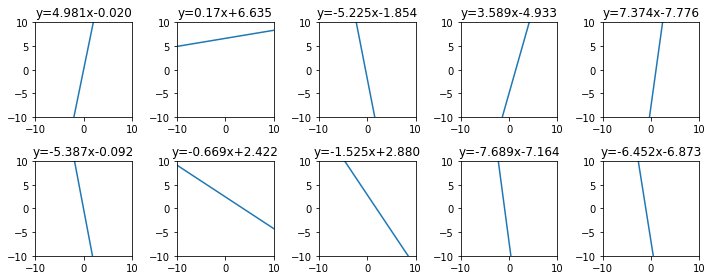

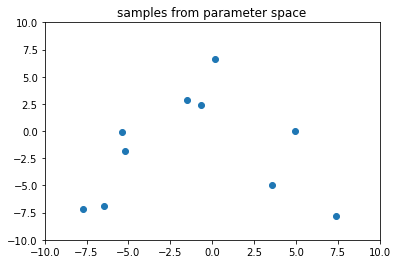

In [1]:
import numpy as np
import matplotlib.pyplot as plt

parameter_points = []
fig1, axes1 = plt.subplots(2, 5, figsize=(10, 4))

for ax in axes1.flatten():
    # np.random.uniform: 정해진 구간에서 수를 무작위로 추출하여 반환합니다.
    a, b = np.random.uniform(-10, 10, size=2)
    a = round(a, 3)
    b = round(b, 3)
    parameter_points.append((a, b))

    x = np.linspace(-10, 10, 50)
    y = a*x + b
    ax.plot(x, y)

    ax.set_title('y='+str(a)+'x'+'{0:+.03f}'.format(b))
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)

plt.tight_layout()

px, py = np.split(np.array(parameter_points), 2, axis=1)
fig2 = plt.figure()
axes2 = plt.gca()

axes2.set_title('samples from parameter space')
axes2.set_xlim(-10, 10)
axes2.set_ylim(-10, 10)

plt.scatter(px, py)
plt.show()

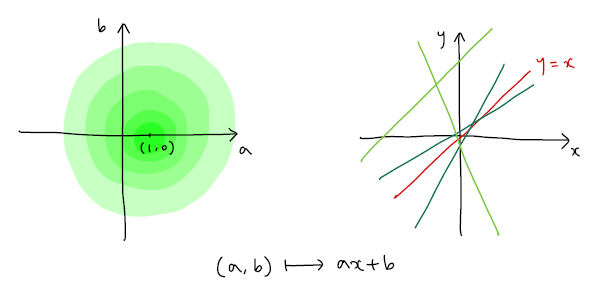

위 그림에서 파라미터 공간에 주어진 확률 분포는 평균이 (1,0)인 정규분포이므로 y=ax+b에서 a와 b의 값이 각각 1과 0에 가까울 확률, 그러니까 모델이 y=x에 가까울 확률이 크다고 보는 것입니다.

왼쪽의 파라미터 공간에서 원소 하나를 뽑은 다음 일차함수의 그래프를 그렸을 때, 모델의 형태가 오른쪽의 진한 초록색 직선들과 비슷할 확률이 클 것이고, 연두색 직선들처럼 기울기나 y절편 차이가 많이 날 확률은 작겠죠.

아래 코드는 평균이 (1,0)이고 표준편차가 0.5인 정규분포에서 10개의 점을 무작위로 뽑은 다음, 대응되는 일차함수의 그래프를 각각 그려주는 코드입니다. 위쪽의 예제와 비교하면 파라미터 공간에서 추출된 샘플들이 (1,0)주위에 모여 있고, 결과 그래프들의 차이가 작은 것을 확인할 수 있습니다.

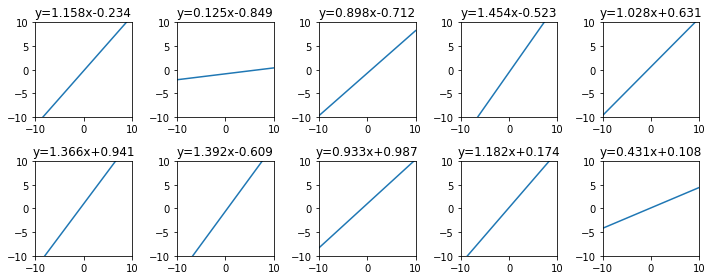

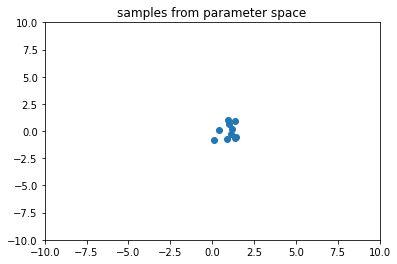

In [2]:
parameter_points = []
fig, axes1 = plt.subplots(2, 5, figsize=(10, 4))

for ax in axes1.flatten():
    # np.random.normal: 정규분포를 따르는 확률 변수의 랜덤한 값을 반환합니다.
    a, b = np.random.normal(loc=[1, 0], scale=0.5)
    a = round(a, 3)
    b = round(b, 3)
    parameter_points.append((a, b))

    x = np.linspace(-10, 10, 50)
    y = a*x + b
    ax.plot(x, y)

    ax.set_title('y='+str(a)+'x'+'{0:+.03f}'.format(b))
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)

plt.tight_layout()

px, py = np.split(np.array(parameter_points), 2, axis=1)
fig2 = plt.figure()
axes2 = plt.gca()

axes2.set_title('samples from parameter space')
axes2.set_xlim(-10, 10)
axes2.set_ylim(-10, 10)

plt.scatter(px, py)
plt.show()

---

## 27.3 posterior와 prior, likelihood 사이의 관계
- 베이지안 머신러닝 모델은 데이터를 통해 파라미터 공간의 확률 분포를 학습합니다. 모델 파라미터를 고정된 값이 아닌 불확실성을 가진 확률 변수로 보는 것, 데이터를 관찰하면서 업데이트되는 값으로 보는 것은 베이지안 머신러닝의 핵심 아이디어입니다.

### 사전 확률, 가능도, 사후 확률(prior, likelihood, posterior)

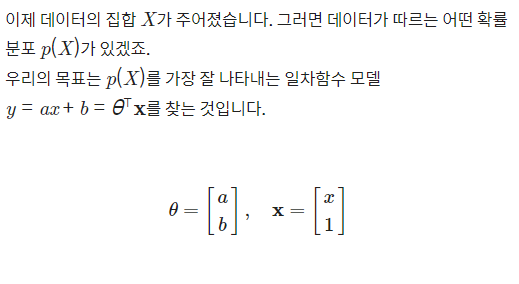

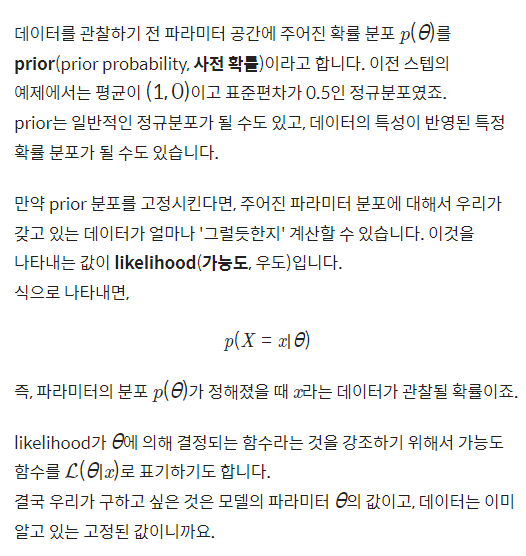

likelihood가 높다는 것은 곧 우리가 지정한 파라미터 조건에서 데이터가 관찰될 확률이 높다는 것이고, 데이터의 분포를 모델이 잘 표현하는 것이라고 생각할 수 있습니다.
이렇게 데이터들의 likelihood 값을 최대화하는 방향으로 모델을 학습시키는 방법을 <mark>최대 가능도 추정(maximum likelihood estimation, MLE)</mark>이라고 합니다.

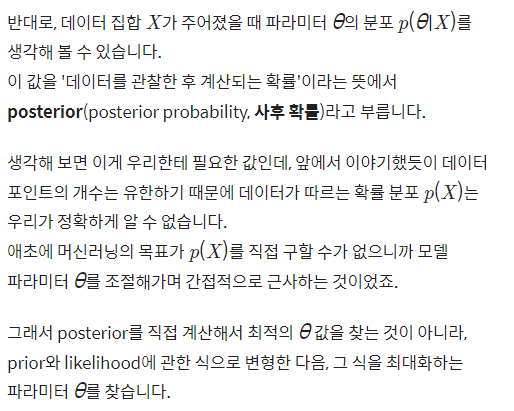

이렇게 posterior를 최대화하는 방향으로 모델을 학습시키는 방법을 <mark>최대 사후 확률 추정(maximum a posteriori estimation, MAP)</mark>이라고 합니다. MLE와 MAP에 대한 자세한 내용은 다음 스텝들에서 다루도록 하겠습니다.

### posterior와 prior, likelihood 사이의 관계

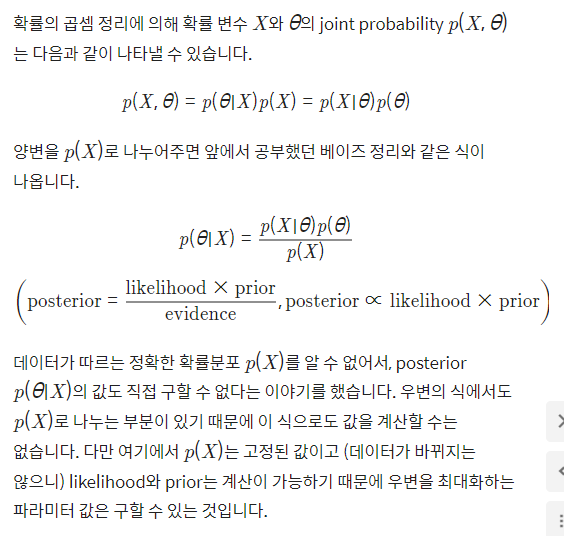

---

## 27.4 likelihood와 머신러닝

머신러닝 모델은 어디까지나 한정된 파라미터로 데이터의 실제 분포를 근사하는 역할을 하기 때문에, 어떤 데이터가 들어와도 100%의 정확도를 내는 모델을 만들기는 불가능합니다. 그래서 모델이 입력 데이터로부터 예측한 출력 데이터(prediction)와 우리가 알고 있는 데이터의 실제 값(label) 사이에는 오차가 생기게 되는데, 우리에게 관찰되는 데이터에는 이미 노이즈가 섞여있어서 이런 오차가 발생한다고 해석합니다.

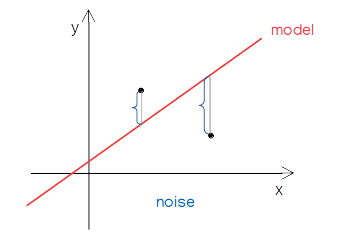



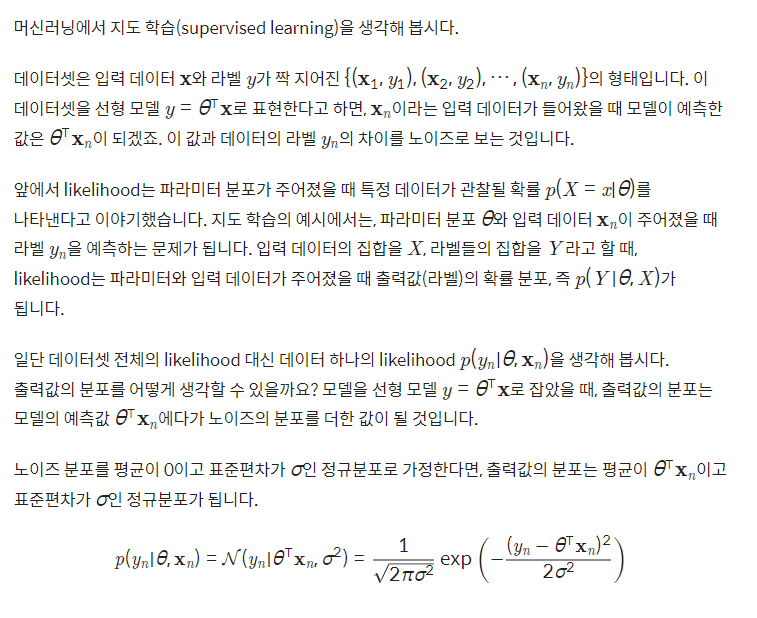

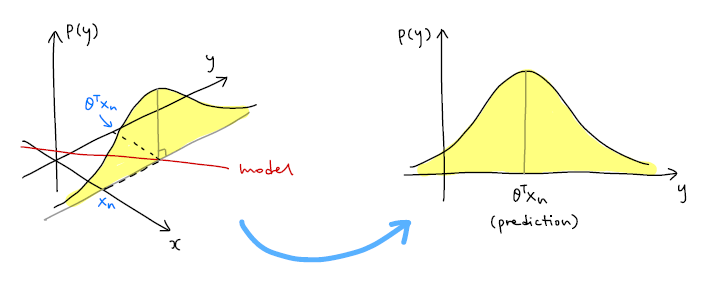

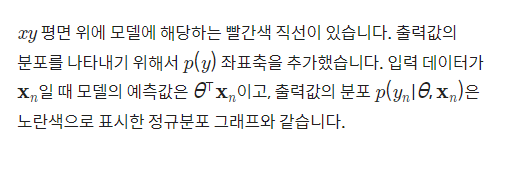

---

## 27.5 likelihood 감 잡기

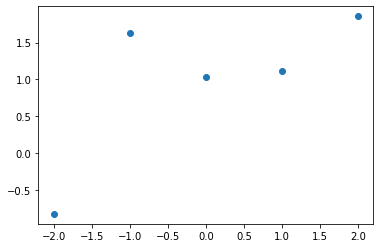

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(321)

input_data = np.linspace(-2, 2, 5)
label = input_data + 1 + np.random.normal(0, 1, size=5)

plt.scatter(input_data, label)
plt.show()

아래 코드에서 일차함수 모델의 식을 바꾸어가며 데이터 포인트 5개의 likelihood 값이 각각 어떻게 바뀌는지 살펴봅시다.
노이즈 분포의 표준편차는 데이터의 실제 분포와 관련된 값이라 우리가 알 수 없지만, 다음 스텝에서 공부할 MLE를 사용하면 표준편차를 알지 못해도 최적의 파라미터 값을 찾을 수 있습니다. 예제에서는 계산을 위해 표준편차를 0.1로 잡았습니다.


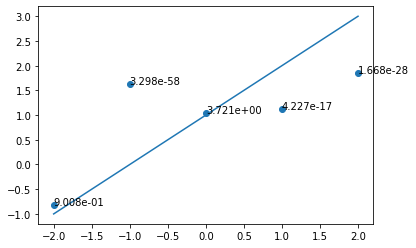

In [8]:
# model: y = ax + b
# a, b 값을 바꾸면서 실행해보세요
#-------------------------------#
a = 1
b = 1
#-------------------------------#

# 모델 예측값
model_output = a*input_data + b
likelihood = []

# x: 입력데이터, y: 데이터라벨
# 예측값과 라벨의 차이를 제곱해 exp에 사용
for x, y, output in zip(input_data, label, model_output):
    likelihood.append(1/(math.sqrt(2*math.pi*0.1*0.1))*math.exp(-pow(y-output,2)/(2*0.1*0.1)))

model_x = np.linspace(-2, 2, 50)
model_y = a*model_x + b

fig, ax = plt.subplots()
ax.scatter(input_data, label)
ax.plot(model_x, model_y)

for i, text in enumerate(likelihood):
    ax.annotate('%.3e'%text, (input_data[i], label[i]))

plt.show()

### likelihood가 왜 중요한가?

위 예제에서 보셨듯이, 데이터 포인트가 모델 함수에서 멀어질수록 데이터의 likelihood는 기하급수적으로 감소합니다. likelihood를 구하는 식을 보면 모델 예측값과 데이터 라벨의 차이를 제곱해서 exponential 위에 올려놓은 것을 확인할 수 있습니다. 예측값과 라벨의 차이가 조금만 벌어져도 likelihood 값은 민감하게 반응하겠죠.
머신러닝의 목표가 데이터 포인트들을 최대한 잘 표현하는 모델을 찾는 것이었다는 사실을 생각하면, 결국 데이터 포인트들의 likelihood 값을 크게 하는 모델을 찾는 것이 됩니다

데이터의 likelihood 값을 최대화하는 모델 파라미터를 찾는 방법이 최대 가능도 추론(maximum likelihood estimation, MLE)입니다. 다음 스텝에서 MLE 방법론을 더 자세히 알아보고 코드를 통해 최적의 모델 파라미터를 계산해 보도록 하겠습니다.

---

## 27.6  MLE: 최대 가능도 추론

### 데이터셋 전체의 likelihood


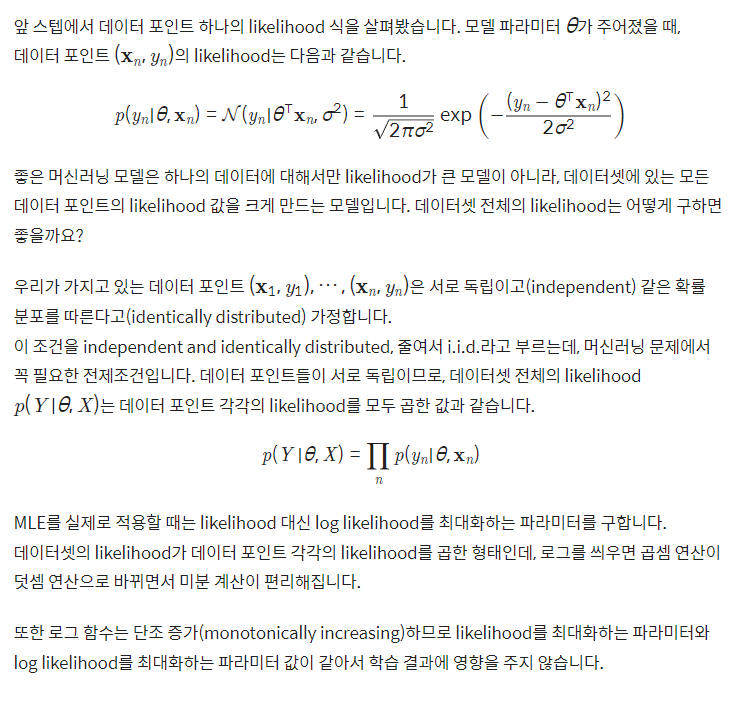

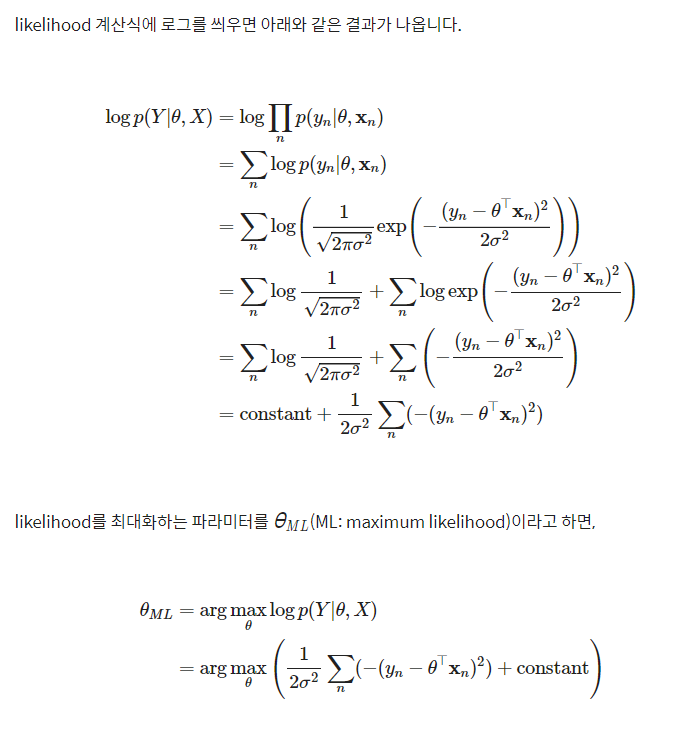

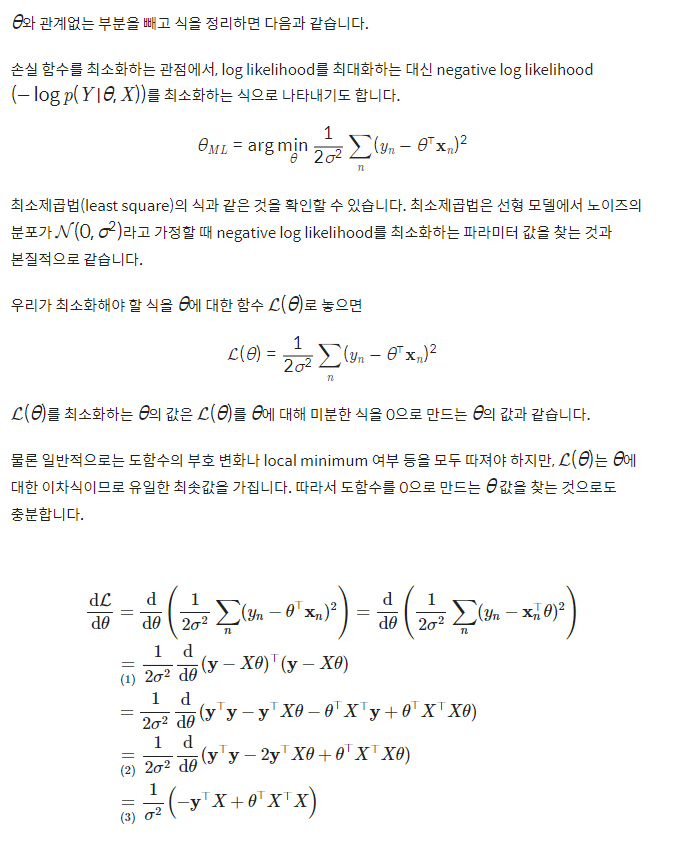

### maximum 'log' likelihood

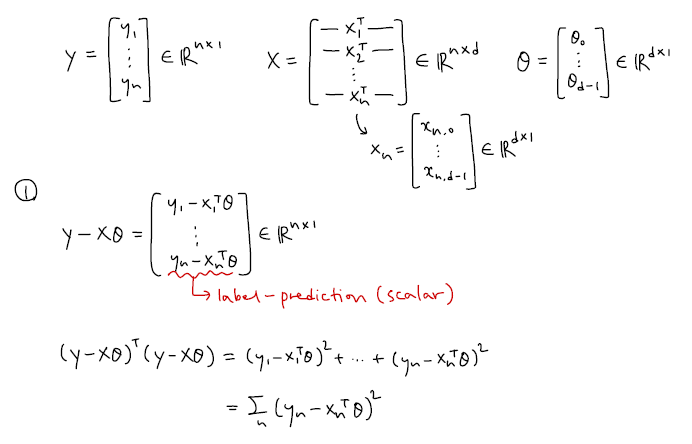

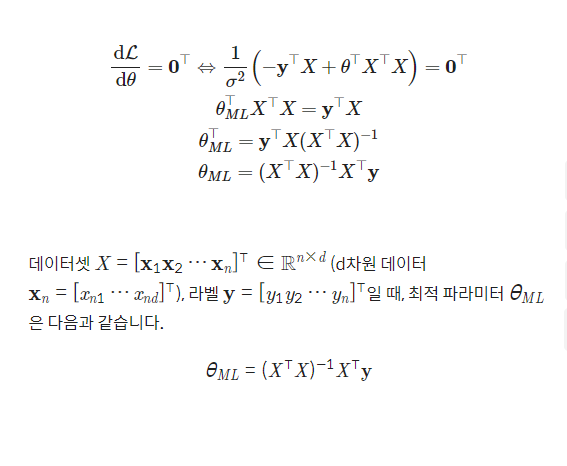

## 27.7 MLE 최적해 구하기

### 데이터셋 생성

MLE를 이용해 최적의 파라미터를 찾아보고 데이터셋의 likelihood도 계산해 보도록 하겠습니다. 아래 코드는 y=x+1 함수를 기준으로 랜덤한 노이즈를 섞어서 데이터 포인트 20개를 생성하고 시각화하는 코드입니다. 데이터 생성 단계에서 지정한 노이즈의 분포는 평균이 0이고 표준편차가 0.5인 정규분포입니다.

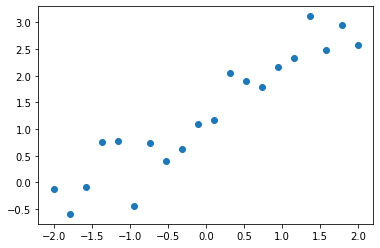

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
num_samples = 20

input_data = np.linspace(-2, 2, num_samples)
labels = input_data + 1 + np.random.normal(0, 0.5, size=num_samples)

plt.scatter(input_data, labels)
plt.show()

### likelihood와 파라미터 계산

데이터를 생성할 때는 노이즈 분포의 표준편차를 0.5로 정했지만 데이터를 관찰하고 모델을 설계하는 입장에서는 노이즈의 원래 표준편차를 알 수 없습니다. 노이즈의 표준편차를 0.1로 가정했다고 합시다. likelihood와 negative log likelihood는 다음과 같이 계산됩니다.

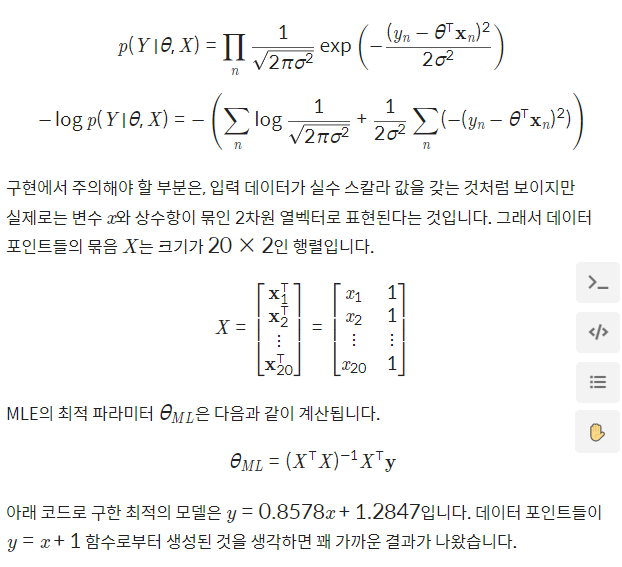

In [10]:
def likelihood(labels, preds):
    result = 1/(np.sqrt(2*math.pi*0.1*0.1))*np.exp(-np.power(labels-preds,2)/(2*0.1*0.1))
    
    return np.prod(result)

def neg_log_likelihood(labels, preds):
    const_term = len(labels)*math.log(1/math.sqrt(2*math.pi*0.1*0.1))

    return (-1)*(const_term + 1/(2*0.1*0.1)*np.sum(-np.power(labels-preds,2)))

slope: 0.8578 bias: 1.2847
likelihood: 2.9724e-54
negative log likelihood: 1.2325e+02


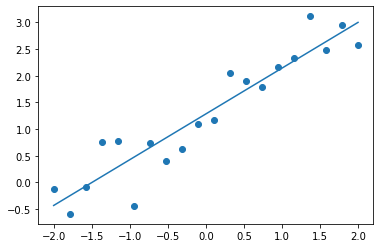

In [11]:
# X: 20x2 matrix, y: 20x1 matrix
# input_data 리스트를 column vector로 바꾼 다음 np.append 함수로 상수항을 추가합니다.
X = np.append(input_data.reshape((-1, 1)), np.ones((num_samples, 1)), axis=1)
y = labels

theta_1, theta_0 = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)

print('slope: '+'%.4f'%theta_1+' bias: '+'%.4f'%theta_0)

predictions = theta_1 * input_data + theta_0
print('likelihood: '+'%.4e'%likelihood(labels, predictions))
print('negative log likelihood: '+'%.4e'%neg_log_likelihood(labels, predictions))

model_x = np.linspace(-2, 2, 50)
model_y = theta_1 * model_x + theta_0

plt.scatter(input_data, labels)
plt.plot(model_x, model_y)
plt.show()

---

## 27.8 MAP: 최대 사후 확률 추정

### prior 분포의 등장

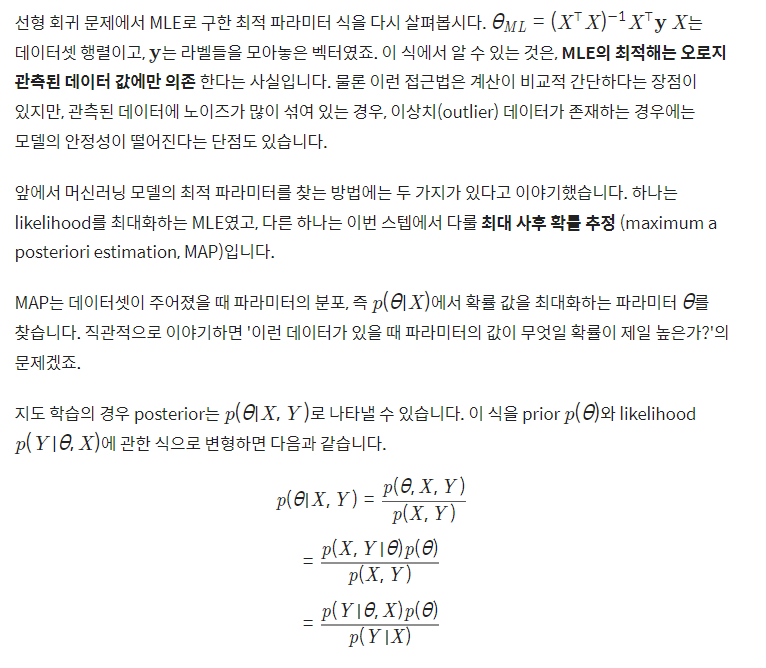

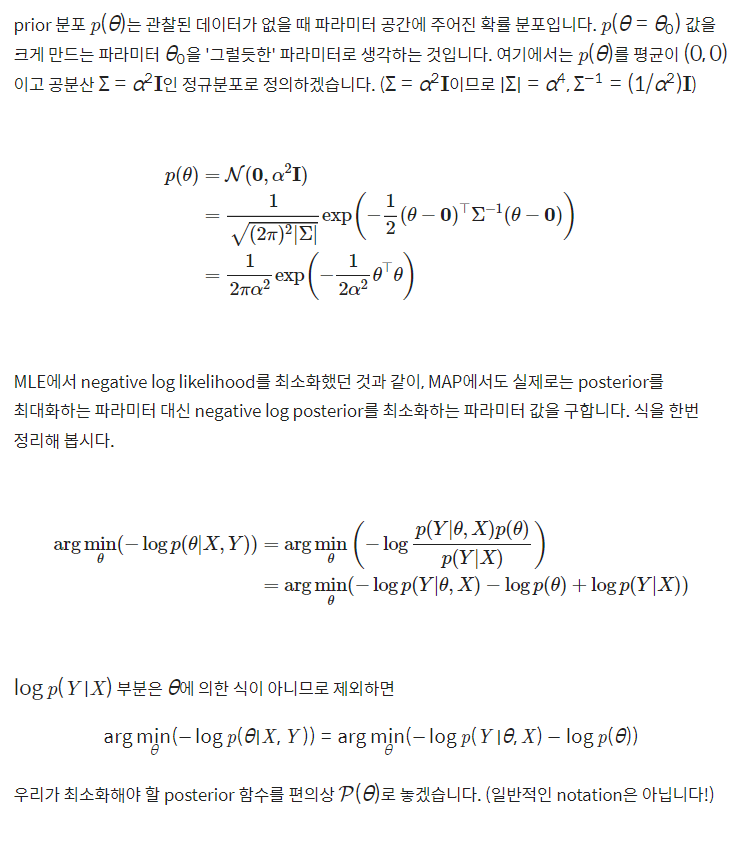

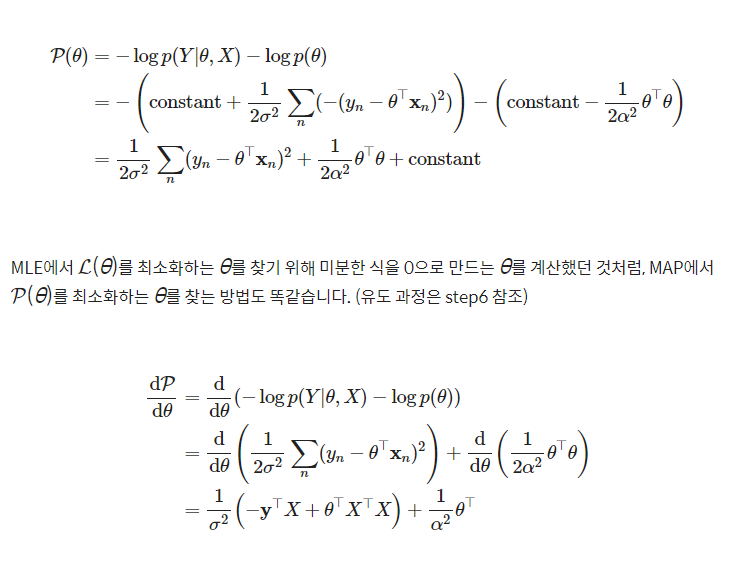

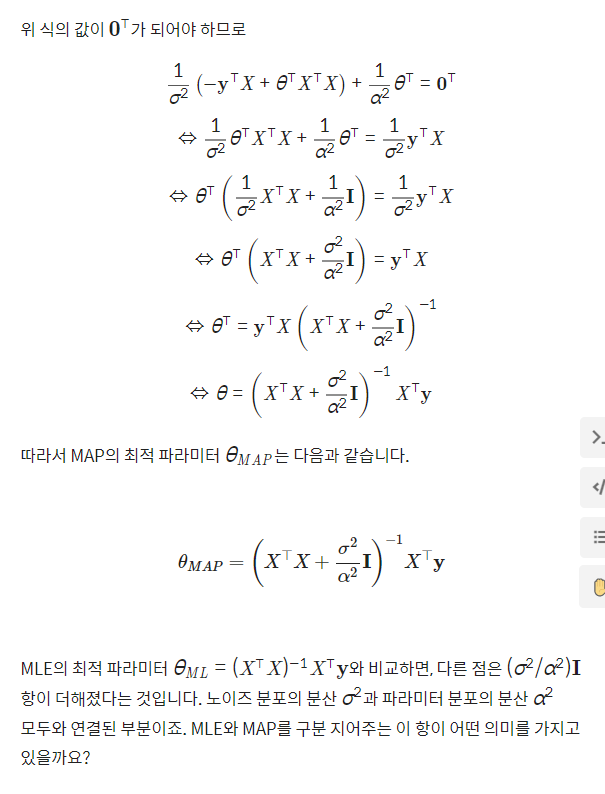

### MAP as L2 regularization

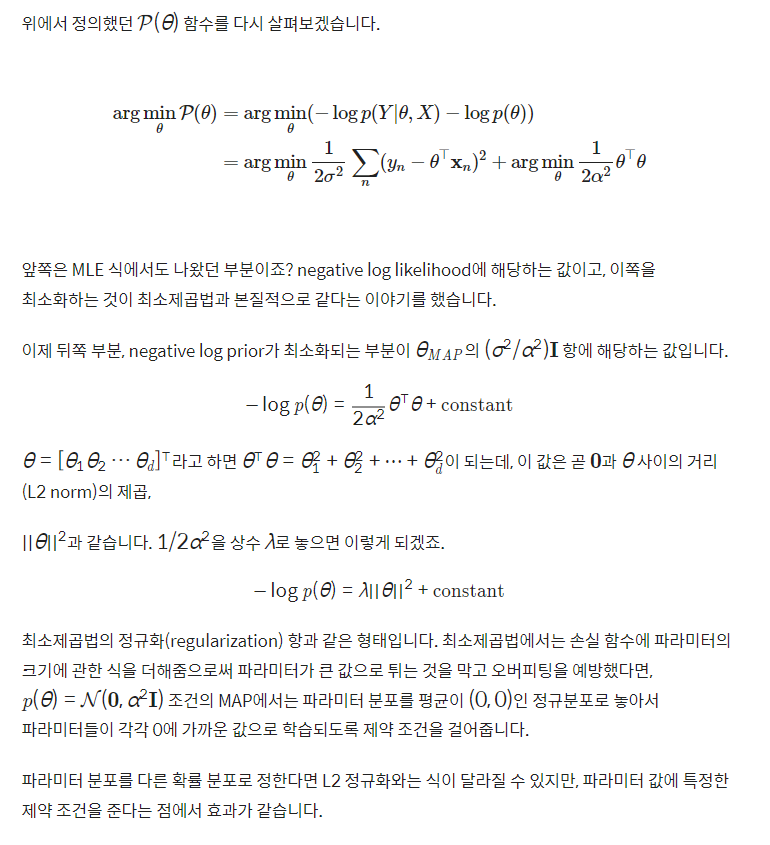

---

## 27.9 MLE와 MAP의 비교


### 데이터셋 생성

MAP는 MLE와 비슷하지만 정규화 항에 해당하는 negative log prior 부분이 존재한다는 차이가 있었습니다. 그래서 MLE 모델보다 MAP 모델이 더 안정적이라는 이야기를 했었죠.
이상치(outlier)가 있는 데이터셋을 이용해서 MAP와 MLE를 비교해 보도록 하겠습니다.

이전 예제와 마찬가지로 y=x+1 함수값에 랜덤한 노이즈를 더해서 데이터 포인트들을 생성하겠습니다.

실험 결과 이상치 데이터 한 개를 데이터 포인트 20개에 추가하는 것으로는 모델에 큰 영향을 주지 못해서 데이터 포인트를 10개로 줄이고 이상치 데이터도 2개 추가합니다.

그래프에서 (0.5, 9) (1.5,10)위치의 이상치 데이터를 확인할 수 있습니다.

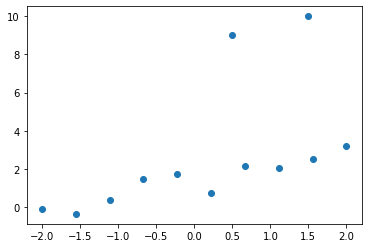

In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
num_samples = 10

input_data = np.linspace(-2, 2, num_samples)
labels = input_data + 1 + np.random.normal(0, 0.5, size=num_samples)

input_data = np.append(input_data, [0.5, 1.5])
labels = np.append(labels, [9.0, 10.0])

plt.scatter(input_data, labels)
plt.show()

### 파라미터 계산

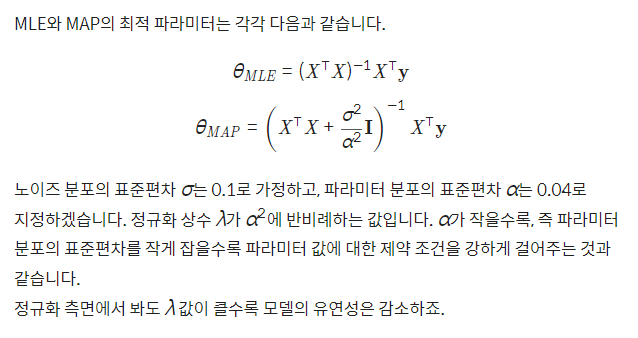

In [13]:
def likelihood(labels, preds):
    result = 1/(np.sqrt(2*math.pi*0.1*0.1))*np.exp(-np.power(labels-preds,2)/(2*0.1*0.1))
    
    return np.prod(result)

def neg_log_likelihood(labels, preds):
    const_term = len(labels)*math.log(1/math.sqrt(2*math.pi*0.1*0.1))

    return (-1)*(const_term + 1/(2*0.1*0.1)*np.sum(-np.power(labels-preds,2)))

[MLE result] (blue)
slope: 1.4748 bias: 2.4784
likelihood: 0.0000e+00
negative log likelihood: 4.1298e+03

[MAP result] (orange)
slope: 1.1719 bias: 1.6628
likelihood: 0.0000e+00
negative log likelihood: 4.6645e+03


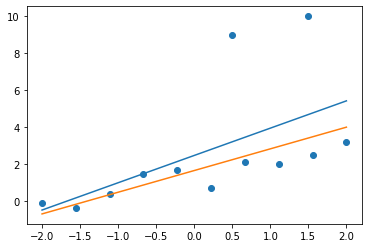

In [14]:
# X: 21x2 matrix, y: 21x1 matrix
# input_data 리스트를 column vector로 바꾼 다음 np.append 함수로 상수항을 추가합니다.
X = np.append(input_data.reshape((-1, 1)), np.ones((num_samples+2, 1)), axis=1)
y = labels

# MLE 파라미터 계산식
mle_theta_1, mle_theta_0 = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
# MAP 파라미터 계산식
map_theta_1, map_theta_0 = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)+(0.1*0.1)/(0.04*0.04)*np.eye(2)), X.T), y)

print('[MLE result] (blue)')
print('slope: '+'%.4f'%mle_theta_1+' bias: '+'%.4f'%mle_theta_0)

mle_preds = mle_theta_1 * input_data + mle_theta_0
print('likelihood: '+'%.4e'%likelihood(labels, mle_preds))
print('negative log likelihood: '+'%.4e\n'%neg_log_likelihood(labels, mle_preds))

print('[MAP result] (orange)')
print('slope: '+'%.4f'%map_theta_1+' bias: '+'%.4f'%map_theta_0)

map_preds = map_theta_1 * input_data + map_theta_0
print('likelihood: '+'%.4e'%likelihood(labels, map_preds))
print('negative log likelihood: '+'%.4e'%neg_log_likelihood(labels, map_preds))

model_x = np.linspace(-2, 2, 50)
mle_model_y = mle_theta_1 * model_x + mle_theta_0
map_model_y = map_theta_1 * model_x + map_theta_0

plt.scatter(input_data, labels)
plt.plot(model_x, mle_model_y)
plt.plot(model_x, map_model_y)
plt.show()

위 그래프에서 파란색 직선과 주황색 직선은 각각 MLE, MAP를 이용해 찾은 모델을 나타냅니다.
파란색 직선은 이상치 데이터까지 포함한 negative log likelihood를 감소시키기 위해 직선이 위로 치우쳐서 아래쪽 10개 데이터의 경향성에서는 약간 벗어났습니다. 반면 주황색 직선은 이상치 데이터가 추가되어도 아래쪽 데이터에서 크게 벗어나지는 않고 있습니다.

원래 데이터 분포에서 멀리 떨어진 이상치 데이터가 추가되었기 때문에, likelihood의 값은 언더플로우가 발생해서 0으로 표시됩니다.
negative log likelihood의 값을 보면 MLE 결과와 MAP 결과를 비교할 수 있습니다. MAP가 MLE에 비해 negative log likelihood 값이 크지만(likelihood가 작지만), 이상치 데이터가 추가되었을 때 모델 파라미터의 변화는 MLE보다 작습니다.